# BEES1041 Exploring the Natural World #
# Week 5 Computer Exercise - Introduction to Python and Spatial Data #
***
This week you will use Python in this Jupyter notebook rather than R. The notebook shows that it is using `Python 3` in the top right corner. It sepcifies version `3` as there was a big change from version 2, and some people still like to use 'Python 2'. Python is very similar to R in many ways, as it is commonly used for scientific coding, it has lots of packages with specialist functions available, which are also refered to as libraries or modules. It also has some key differences to R, such as:
- Python doesn't use the `<-` symbol, it just uses the equal sign `=`.
- When counting, Python starts from 0 rather than 1.
- Python doesn't let you import functions with the same name.
- In Python you normally call a function from a module using the format `module.function()`.
- It is a general-purpose programming language, while R has its roots in statistical analysis.

The notebook is split into two exercises. First you will be introduced to some basic python code, to see how it works. Secondly, we will use spatial data to make some global maps, to learn how you can code with spatial data as well as spreadsheet data, and to see how different projections change the shape of the globe. Some of the cells in the latter part of the notebook might take a couple of minutes to run, but just wait until the `[*]` finishes to see the output.

***
## Part 1. Introduction to Python ##
First you will see some common Python objects and functions. In Python and R, a text object is refered to as a `string` and is defined using either the single `''` or double quotes `""`. You can easily create variables to store strings. For example, in the next code cell, you create a variable called `x` which stores the string `"Hello world!"`. You can then print the string in the output using the function `print()`.

In [1]:
x = "Hello World!"
print(x)

Hello World!


Printing a string that you have just defined like this may not seem very useful, but it illustrates the idea of storing strings in a variable. You can also create variables to store numbers, which you can then do calculations on. For example, the following code cell creates a variable called `a` that stores the value `23.56`, while variable `b` stores the value `2`, which we can multiply together.

In [2]:
a = 23.56
b = 2
a * b

47.12

A common python object is called a `list`, which you can create with the square brackets `[]`. Python lists can store anything, so you can make a list called `c`, which will contain the values for `x`, `a` and `b` that we have already created. You can use the `print()` function to see what is in the list `c`. Functions like `print()` use round brackets, while lists use square brackets.

In [3]:
c = [x, a, b]
print(c)

['Hello World!', 23.56, 2]


The position of each item in a list is determined by its `index`, which is just a sequence of integer numbers starting from 0. To access the first item in list `c`, we can use `c[0]`.

In [4]:
c[0]

'Hello World!'

You can add items to a list so that it grows. Lets add the number 42 to our list `c`.

In [5]:
c.append(45)
print(c)

['Hello World!', 23.56, 2, 45]


You can also change items in a list. Lets replace the number 23.56 in `c` with the word "Goodbye".

In [6]:
c[1] = "Goodbye"
print(c)

['Hello World!', 'Goodbye', 2, 45]


A python object similar to a list, but which cannot be changed, is called a `tuple`. These are sometimes used by programmers to store groups of values, such as the coordinates of the corners of an image. The following cell creates a tuple called `t`, which stores two values, just by useing round brackets `()`. Values in tuples are indexed the same as lists, using square brackets. If you try and change the value in a tuple you will get an error.

In [7]:
t = (56, 87)
print(t[0])

56


The most common Python objects used in scientific coding are `numpy` arrays. A `numpy` array is like a matrix, with rows and columns of numerical values, which is defined using functions from the `numpy` module. For example, when you read a satellite image into memory, the pixel values are stored as a `numpy` array. The following code creates a small array with 3 rows and 3 columns.

In [8]:
import numpy

a = numpy.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
print(a)

[[1 2 3]
 [4 5 6]
 [7 8 9]]


To access values in a `numpy` array you can use the index position inside square brackets. Because the array called `a` has rows and columns, it needs 2 indexes. The following code prints the value in the first row and first column. Numpy arrays, like lists, start counting from zero.

In [9]:
a[0, 0]

1

You can do mathematical and statistical operations on numpy arrays. The following cell adds 2 to all values in the the array `a`. 

In [10]:
a + 2

array([[ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11]])

You can add arrays together, like in the next cell.

In [11]:
b = numpy.array([[12, 11, 10], [9, 8, 7], [6, 5, 4]])
a + b

array([[13, 13, 13],
       [13, 13, 13],
       [13, 13, 13]])

And you can calulate the average of an array, using the `numpy.mean()` function.

In [12]:
numpy.mean(a)

5.0

***
## Part 2. Plotting spatial data ##
Now that you have seen some Python code, you will use it to plot some spatial data. I could have shown you how to read data from CSV files, conduct statistical analyses, and make plots using Python, just like you've learned in R. Instead of showing how to do the same thing, I thought you could look at plotting spatial data, which is an area where Python is really good. For example, the [Digital Earth Australia Sandbox](https://www.dea.ga.gov.au/) uses Python in Jupyter Notebooks to allow users to access and analyse spatial data all over Australia, using a special Python module called `datacube`. Here is an example of a notebook on the DEA Sandbox:

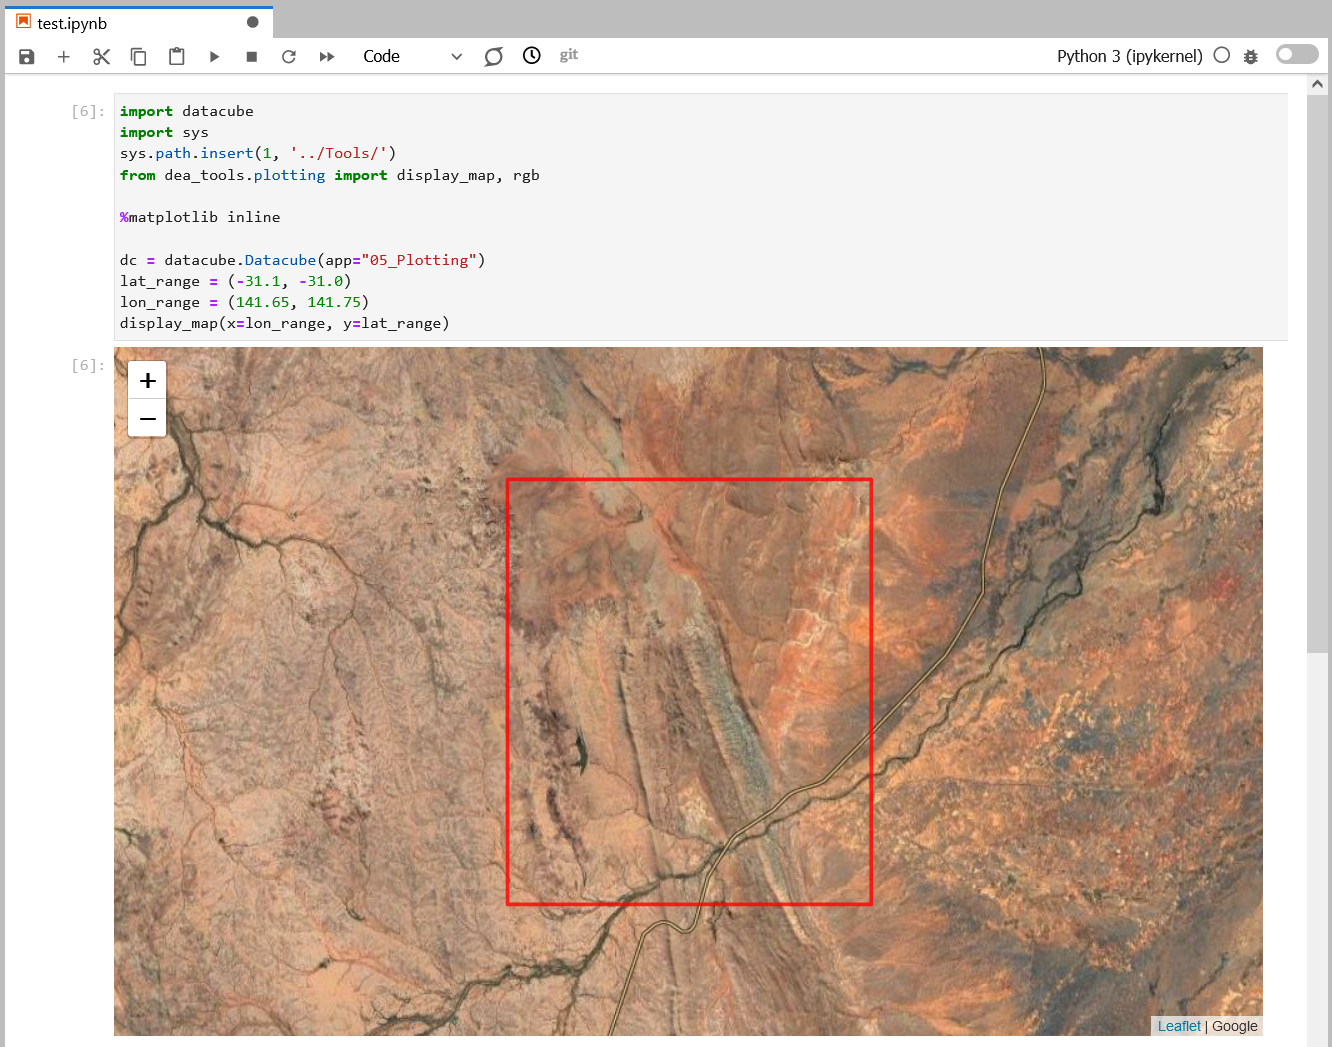

You should have downloaded a file called `global_gebco.tif` from Moodle, and uploaded it into your Jupyter lab environment. This file is a raster dataset of global topography and bathymetry (elevation above and below sea level) that I downloaded from [GEBCO](https://www.gebco.net/data_and_products/gridded_bathymetry_data/). I processed the data to make it a smaller file size, and easier to work with. Raster data is stored as a grid, or image, where the grid cells (or image pixels) are just numbers arranged in rows and columns. This makes them perfect to be read as `numpy` arrays. In order to read the GEBCO data with python, we need to import the `gdal` module. [GDAL](https://gdal.org/) is a translator library for raster and vector geospatial data formats, and is used by QGIS and ArcGIS. The following code imports the `gdal` library, then opens the GEBCO data and reads it in as a `numpy array`. 

In [13]:
from osgeo import gdal

demFile = "global_gebco.tif"
ds = gdal.Open(demFile)
demArray = ds.ReadAsArray()
print(demArray)

[[-4221 -4221 -4221 ... -4220 -4220 -4221]
 [-4214 -4213 -4213 ... -4215 -4215 -4215]
 [-4221 -4221 -4221 ... -4220 -4220 -4220]
 ...
 [ 2887  2887  2887 ...  2887  2887  2887]
 [ 2859  2859  2859 ...  2859  2859  2859]
 [ 2843  2843  2843 ...  2843  2843  2843]]


From the print statement, we can see that the GEBCO data was read as a grid of numbers, which are the elevation of the Earth's surface. Negative and positive numbers correspond to metres below and above sea level. You can see the number of rows and columns that the array has by using the `numpy.shape()` function.

In [14]:
numpy.shape(demArray)

(1800, 3600)

You can calculate the average elevation of the Earth using the `numpy.mean()` function.

In [15]:
numpy.mean(demArray)

-1898.4885276234568

You can use Pythons main plotting library, called `matplotlib`, to plot the image, using the following code. This first defines a plot size (in inches), then adds an axes object, then adds the image. It colours the image with the `jet` colormap, which goes from blue to yelow to red as the values get larger.

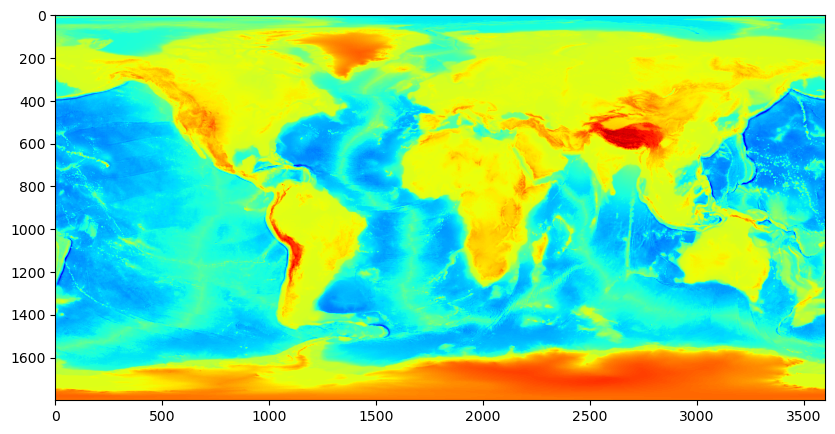

In [16]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(demArray, cmap='jet')
plt.show()

The axes of the plotted image above are labeled with the row and column numbers of the array, and it is not a proper map. In order to make a proper map, you need to define the coordinate reference system, just like you did in QGIS. The Python module called `cartopy` makes doing this easy. The following cell creates a plot of the globe in the Mercator projection. It uses an image of the globe that is part of the cartopy library.

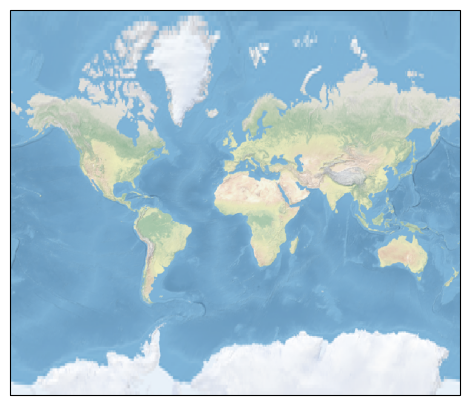

In [17]:
import cartopy.crs as ccrs

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
ax.set_global()
ax.stock_img()
plt.show()

The next cell lets you explore the way different projections change the shape of the globe. Projections are required because the globe is a sphere but maps are flat. The code creates a plot with three subplots, which each use different projections. The main function used is `add_subplot(rows, columns, index, projection)`, which controls the layout of the plot.

ValueError: 'x' must be finite, check for nan or inf values

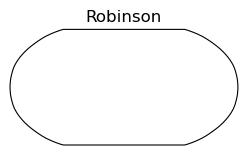

In [18]:
fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(1, 3, 1, projection=ccrs.Robinson())
ax1.set_title('Robinson')
ax1.set_global()
ax1.stock_img()

ax2 = fig.add_subplot(1, 3, 2, projection=ccrs.Mercator())
ax2.set_title('Mercator')
ax2.set_global()
ax2.stock_img()

ax3 = fig.add_subplot(1, 3, 3, projection=ccrs.Mollweide())
ax3.set_title('Mollweide')
ax3.set_global()
ax3.stock_img()

plt.show()

In order to plot the GEBCO data on the global map we need to know the CRS and the extent of the data. The CRS was listed on the website as being unprojected, which means it is defined by a grid of latitude and longitude. This is known by various names, such as a geographic projection, while `cartopy` uses the name plate carrée projection (which means flat square in French). The extents of the GEBCO data can be read using the GDAL function `GetGeoTransform()`, which returns a tuple.

In [ ]:
gt = ds.GetGeoTransform()
print(gt)

The variable gt is a set of [6 values that define the geometry of the image](https://gdal.org/tutorials/geotransforms_tut.html).
- `gt[0]` is the x-coordinate of the upper-left corner of the upper-left pixel.
- `gt[1]` is the w-e pixel resolution (pixel width).
- `gt[2]` is the row rotation (typically zero).
- `gt[3`  is the y-coordinate of the upper-left corner of the upper-left pixel.
- `gt[4]` is the column rotation (typically zero).
- `gt[5]` is the n-s pixel resolution (pixel height), which is negative for a north-up image.

Cartopy needs the coordinates of the bottom, top, left and right of the image, which we can calculate from the values in gt, to create a tuple called extent. To make these calculations we also need the number of columns and rows, which we can get from the `numpy.shape()` function.

In [ ]:
(rows, columns) = numpy.shape(demArray)
extent = (gt[0], gt[0] +  columns * gt[1],
          gt[3] +  rows * gt[5], gt[3])
print(extent)

Now we have enough information to project the GEBCO data on a cartopy map. Lets see what it looks like when the map has the Robinson projection. We need to define the `extent` and the `transform` of the image, but we can define any projection for the axes of the map. If you want to see what other projections look like, you can find the full list of possible projections on the [Cartopy](https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html) website. Try some of them out by changing `ccrs.Robinson()` to some other projections, such as `ccrs.Sinusoidal()` or `ccrs.InterruptedGoodeHomolosine()`.

In [ ]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())
ax.set_global()
ax.imshow(demArray, cmap='jet', origin='upper', extent=extent, transform=ccrs.PlateCarree())
plt.show()

In the map above it is hard to see the coastlines, where elevation is zero. To show these easier, I downloaded a dataset of global coastlines from the US [National Oceanic and Atmospheric Administration](https://www.ngdc.noaa.gov/mgg/shorelines/). I had to convert the data to a shapefile, and simplify it to reduce its size, but it is great to overlay on the GEBCO data. This shapefile consists of the following four files, which you need to download from Moodle and upload to your notebook environment.
- world-coastline.shp
- world-coastline.shx
- world-coastline.dbf
- world-coastline.prj

You can open this shapefile and the GEBCO image in QGIS and see what they look like. We can also add the shapefile to the Cartopy map using the following code.

In [ ]:
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

shapefile = "world-coastline.shp"
shape_feature = ShapelyFeature(Reader(shapefile).geometries(), ccrs.PlateCarree(),
                               facecolor='none', edgecolor='black', linewidth=0.5)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())
ax.set_global()
ax.imshow(demArray, cmap='jet', origin='upper', extent=extent, transform=ccrs.PlateCarree())
ax.add_feature(shape_feature)
plt.show()

Although this map is starting to look good, there a few other things you can do to improve it.
- Adding grid lines to show latitude and longitude would help.
- Including a scale bar to show what values the colours represent would be good.
- Lets also change the projection so the map highlights Australia in in the centre.

The following code cell shows how adding grid lines is very easy with the `gridlines()` function. The `Orthographic()` projection shows the globe as from space, and setting the `central_longitude=135` and `central_latitude=-30` centres the map on Australia. Adding a colour scale bar is a little trickier, as it requires creating another axis and defining the maximum and minimum elevation values. The second last line of code saves the map as a PNG image, which you can download and keep.

In [ ]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Orthographic(central_longitude=135, central_latitude=-30))
ax.set_global()
im = ax.imshow(demArray, cmap='jet', origin='upper', extent=extent, transform=ccrs.PlateCarree(), vmin=-6000, vmax=4000)
ax.add_feature(shape_feature)
ax.gridlines()

cbaxes = fig.add_axes([0.7, 0.1, 0.2, 0.01])
cbar = plt.colorbar(im, orientation='horizontal', cax=cbaxes, ticks=[-6000, 0, 4000])
cbar.set_label('Elevation (m)')

plt.savefig("globe_jet.png", dpi=300)
plt.show()

This is the end of the exercise. You have learned about some basic Python objects and functions that can be used for scientific analysis. You have also learned how spatial data can be plotted in Python using the gdal, matplotlib and cartopy modules. By experimenting with different projections, you have also seen how all global maps need to distort the round surface to a flat plane. That is why I like using the orthographic projection, which maintains the spherical shape, even if it can't show the whole world.

***
# Final instructions #
There are a few things you need to do:
- Dont forget to answer the Moodle quiz questions for this exercise.
- If you have any problems, or questions, please post on the Moodle forum.
- Save the completed notebook and download it to your computer, as SWAN scratch directories get emptied. Or you can move the files into your Cloustor directory.

***
# Further exercises #
It would be interesting to create a similar map to the one above, but zoomed in on Australia. Have a go at doing this by adding a code cell, copying the cell that made the last map, and make the following changes to the code:
- Make the figure size 8 x 8 inches.
- Instead of using `ax.set_global()` use `ax.set_extent([110, 155, -5, -45], crs=ccrs.PlateCarree())`, to zoom in on Australia.
- Change the maximum elevation to 2000 m, as Australia's highest mountain is only 2228 m.

Go to the website for more information on using [Cartopy](https://scitools.org.uk/cartopy/docs/latest/index.html). The [Gallery](https://scitools.org.uk/cartopy/docs/latest/gallery/index.html) is particularly good to see what is possible. 